# PREDICTOR DE FRUTAS Y VEGETALES CON RED NEURONAL CONVOLUCIONAL
---
```
Autor     : Etson Ronaldao Rojas Cahuana
Fecha     : 14/05/2023
Lugar     : Cusco, Perú
Proposito : Diseñar una Red Neuronal Convolucional (CNN) y entrenarla para realizar clasificación con el conjunto de datos de frutas y vegetales que se adjunta. 
```
---

Importar librerias necesarias

In [53]:
import os
import keras
import matplotlib
import subprocess
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.python.platform import build_info as build
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

In [54]:
print("Tensorflow".ljust(25) + f":{tf.__version__}")
print("Keras".ljust(25) + f":{keras.__version__}")
print("GPU Available".ljust(25) + f":{len(tf.config.experimental.list_physical_devices('GPU'))}")
print("Cuda Built".ljust(25) + f":{tf.test.is_built_with_cuda()}")
print("Cuda Version".ljust(25) + f":{build.build_info['cuda_version'].split('_')[1][:2]}" +"."+ f"{build.build_info['cuda_version'].split('_')[1][2:]}")
print("Cudnn Version".ljust(25) + f":{build.build_info['cudnn_version'].split('_')[1]}")
print("List Tensorflow GPUs".ljust(25) + f":{tf.config.list_physical_devices('GPU')}")
print("Name of GPU".ljust(25) + f":{subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]}")
print("Numpy Version".ljust(25) + f":{np.__version__}")
print("Pandas Version".ljust(25) + f":{pd.__version__}")
print("Matplotlib Version".ljust(25) + f":{matplotlib.__version__}")

Tensorflow               :2.10.1
Keras                    :2.10.0
GPU Available            :1
Cuda Built               :True
Cuda Version             :11.2
Cudnn Version            :8
List Tensorflow GPUs     :[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name of GPU              :NVIDIA GeForce RTX 3070 Ti Laptop GPU
Numpy Version            :1.22.3
Pandas Version           :1.5.3
Matplotlib Version       :3.7.1


# a) Lectura y preprocesamiento de datos (generador de imágenes)

## a.1) Acerca del dataset

El dataset utilizado es el [Fruit Classification](https://www.kaggle.com/datasets/sshikamaru/fruit-recognition) que contiene: 

- **train**: La carpeta de entrenamiento que contiene 33 subcarpetas en las cuales se encuentran las imágenes de entrenamiento para cada fruta/vegetal. Hay un total de 16854 imágenes.
- **test**: La carpeta de prueba que contiene 5641 imágenes de prueba.
- **sampleSubmission.csv**: Un archivo de muestra de envío en el formato correcto, con números de identificación y etiquetas en formato de cadena.


## a.2) Lectura y preprocesamiento

En la lectura de los datos se genera dos conjuntos, para el entrenamiento y para la validación de los cuales:
- 80% de datos para entrenamiento
- 20% de los datos para validación

Considerar que se realiza un preprocesamiento de las imagenes:
- Cada imagen esta en 3 canales (RGB) por lo cual ocupa una dimension 3
- Se realiza una rescalacion a 255 bits de color
- Se realiza una transformación que desplaza los puntos de una imagen en una dirección determinada con 0.2
- Considerar un zoom factor de 0.2

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2
)
print('TOTAL DE DATOS')
total_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Fruit Classification/train',
    batch_size=32,
    image_size=(100,100),
    shuffle=True,
)

print('\nTOTAL DE DATOS PARA ENTRENAMIENTO')
train_generator = train_datagen.flow_from_directory(
    directory='Fruit Classification/train', 
    target_size=(100, 100), 
    batch_size=32,  
    class_mode='categorical', 
    subset='training')

print('\nTOTAL DE DATOS PARA LA VALIDACIÓN')
validation_generator = train_datagen.flow_from_directory(
    directory='Fruit Classification/train',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

TOTAL DE DATOS
Found 16854 files belonging to 33 classes.

TOTAL DE DATOS PARA ENTRENAMIENTO
Found 13493 images belonging to 33 classes.

TOTAL DE DATOS PARA LA VALIDACIÓN
Found 3361 images belonging to 33 classes.


## a.3) Mostrar un elemento de cada clase

Se muestra las imagenes con las que se estan trabajando, en este caso una por cada clase.

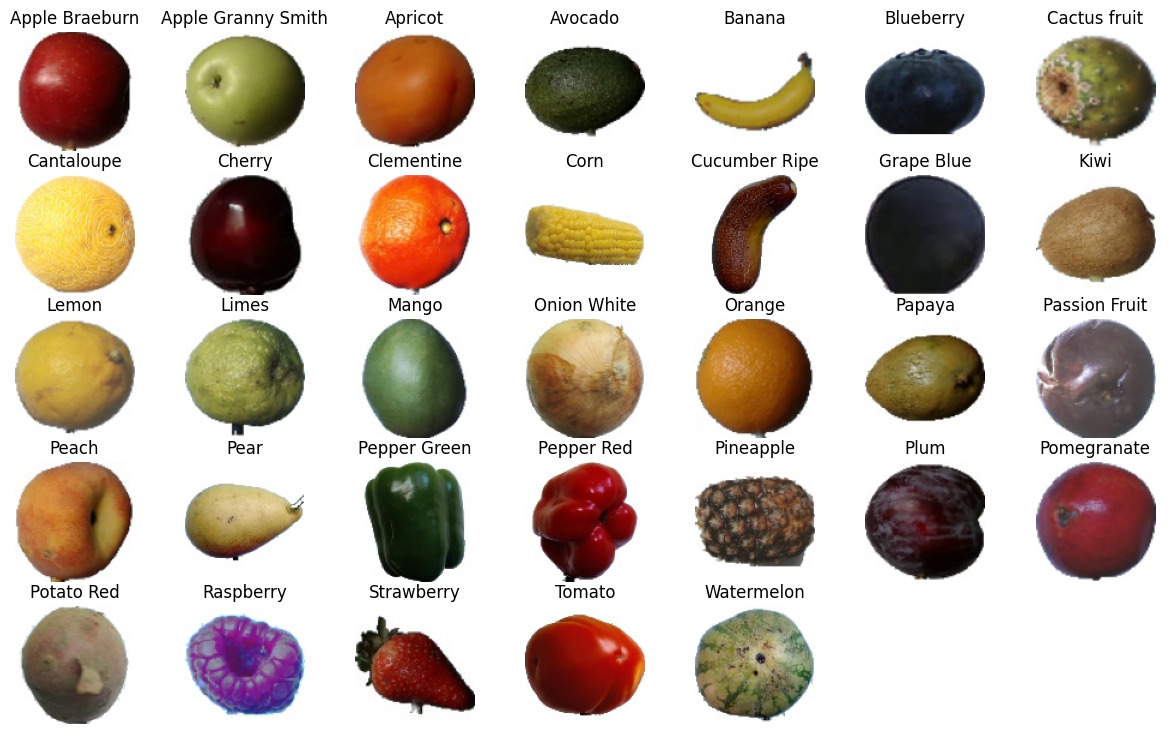

In [4]:
# Obtener lista de nombres de las clases
class_names = os.listdir('Fruit Classification/train')

# Crear figura
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(15,9))

# Iterar por las clases
for i, class_name in enumerate(class_names):
    # Obtener la primera imagen de cada clase
    img_path = os.path.join('Fruit Classification/train', class_name, os.listdir(os.path.join('Fruit Classification/train', class_name))[0])
    img = load_img(img_path, target_size=(100, 100))
    
    # Plotear la imagen
    row = i // 7
    col = i % 7
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis("off")

# Ocultar los dos últimos subplots
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

#Mostrar plot
plt.show()

# b) Construcción del modelo

Creacion del modelo convolucional y tuneado con los hiperparametros

In [5]:
#Crear modelo secuencial
cnn = tf.keras.models.Sequential()
#Añadir capa convolucional y un maxpool
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',input_shape = (100, 100, 3), padding="valid"))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))
cnn.add(tf.keras.layers.Dropout(0.15))
#Añadir capa convolucional y un maxpool
cnn.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))
cnn.add(tf.keras.layers.Dropout(0.10))
#Aplanar las capas de convolución
cnn.add(tf.keras.layers.Flatten())
#Conecta completamente las capas
cnn.add(tf.keras.layers.Dense(units = 16, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.05))
#cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
#Capa de salida
cnn.add(tf.keras.layers.Dense(units = 33, activation = 'softmax'))
#Mostrar resumen de modelo
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 16)       6

# c) Entrenamiento del modelo

Para el entrenamiento del modelo creado anteriormente se utilizo GPU de google colaboratory, con esto se agiliza el tiempo que se entrena pasando de 300 segundos promedio por epoca a 20 segundos promedio, se utiliza la funcion de pérdida de entropía cruzada por tener dos o más clases de etiquetas.

In [6]:
logdir = "logs/fit"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
#Compilar modelo
cnn.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
#Se utiliza una activacion para una parada anticipada y evitar el sobreajuste
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10,verbose = 1)
#Reducir la tasa de aprendizaje cuando el aprendizaje se estanca
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
tb = TensorBoard(log_dir = logdir)
#Entrenar el modelo cnn y guardar el historial en model
model = cnn.fit(x = train_generator, validation_data = validation_generator, epochs = 15, callbacks = [rlr, es, tb])

Epoch 1/15
422/422 [==============================] - 38s 78ms/step - loss: 2.0787 - accuracy: 0.3927 - val_loss: 3.1465 - val_accuracy: 0.2041 - lr: 0.0010
Epoch 2/15
422/422 [==============================] - 24s 57ms/step - loss: 0.6046 - accuracy: 0.8204 - val_loss: 1.1931 - val_accuracy: 0.6584 - lr: 0.0010
Epoch 3/15
422/422 [==============================] - 25s 59ms/step - loss: 0.2703 - accuracy: 0.9160 - val_loss: 0.1722 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/15
422/422 [==============================] - 45s 106ms/step - loss: 0.2386 - accuracy: 0.9257 - val_loss: 0.1054 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 5/15
422/422 [==============================] - 28s 66ms/step - loss: 0.1775 - accuracy: 0.9461 - val_loss: 0.0590 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/15
422/422 [==============================] - 43s 103ms/step - loss: 0.1530 - accuracy: 0.9515 - val_loss: 0.0276 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 7/15
422/422 [==============================] - 32

Guardar modelo

In [7]:
cnn.save('Fruit Classification/model_cnn_fruits.h5')

# d) Evaluación del modelo y gráficas de entrenamiento y validación (accuracy - loss)

## d.1) Valores historicos de entrenamiento

Obtenemos los valores historicos de entrenamiento, para observar como va mejorando epoca por epoca en base a la funcion de perdida en los datos de entrenamiento y validación.

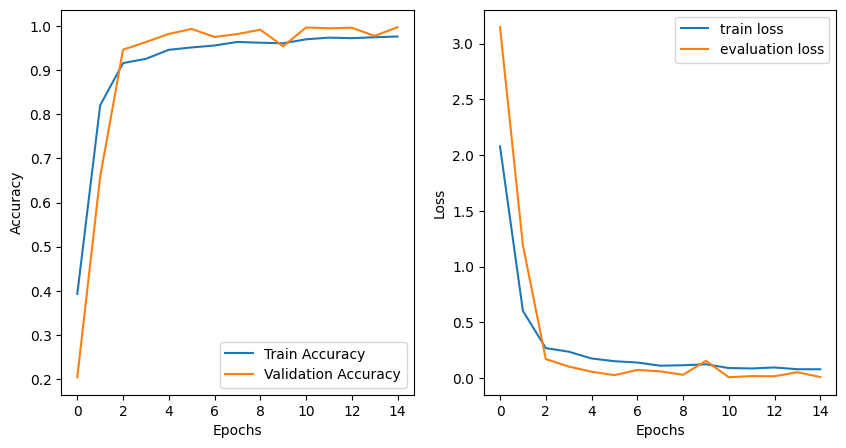

In [50]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(model.history['accuracy'], label='Train Accuracy')
ax.plot(model.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(model.history['loss'], label='train loss')
ax.plot(model.history['val_loss'], label='evaluation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss');

## d.2) Evaluar desempeño del modelo entrenado

Para evaluar el desempeño con los datos, se itera cada carpeta extrayendo su etiqueta y guardando cada resultado en un vector, al final sacar un promedio aritmetico de todos los datos acertados con la cantidad de datos evaluados.

In [16]:
# cargar modelo
cnn = load_model('Fruit Classification/model_cnn_fruits.h5')

In [51]:
# Evaluar modelo con datos de entrenamiento
train_loss, train_acc = cnn.evaluate(train_generator, verbose=True)

# Evaluar modelo con datos de validación
val_loss, val_acc = cnn.evaluate(validation_generator, verbose=True)

# Crear un diccionario con los datos
data = {
    'Métrica': ['Precisión (accuracy)', 'Total de datos', 'Predicciones correctas'],
    'Entrenamiento': [train_acc, train_generator.n, str(int(train_acc*train_generator.n))],
    'Validación': [val_acc, validation_generator.n, str(int(val_acc*validation_generator.n))]
}

# Crear el DataFrame a partir del diccionario
df = pd.DataFrame(data)

# Mostrar el DataFrame
print('\n'+df.to_string(index=False))

106/106 [==============================] - 5s 48ms/step - loss: 0.0096 - accuracy: 0.9985

               Métrica Entrenamiento Validación
  Precisión (accuracy)      0.998592   0.998512
        Total de datos         13493       3361
Predicciones correctas         13473       3355


# e) Predicciones con el modelo entrenado

Se realiza la prediccion con los datos de test, mostraremos las imagenes y la clase a que resulta.

## e.1) Predecir una sola imagen

Leer una imagen del directorio de test, mostrar la imagen junto con la prediccion.

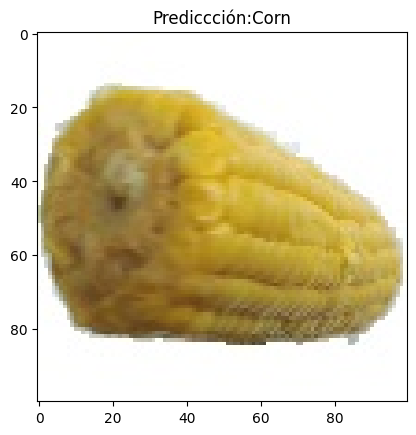

In [31]:
#Leer imagen del directorio
img = Image.open('Fruit Classification/test/0216.jpg')
test_image = np.asarray(img)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image / 255.0,verbose=False)
max_index = np.where((result == np.amax(result))[0])[0][0]
predicted_species = total_data.class_names[max_index]

plt.imshow(img)
plt.title('Prediccción:'+predicted_species)
plt.show()

## e.2) Predecir varias imagenes

Predecir 36 primeras imagenes

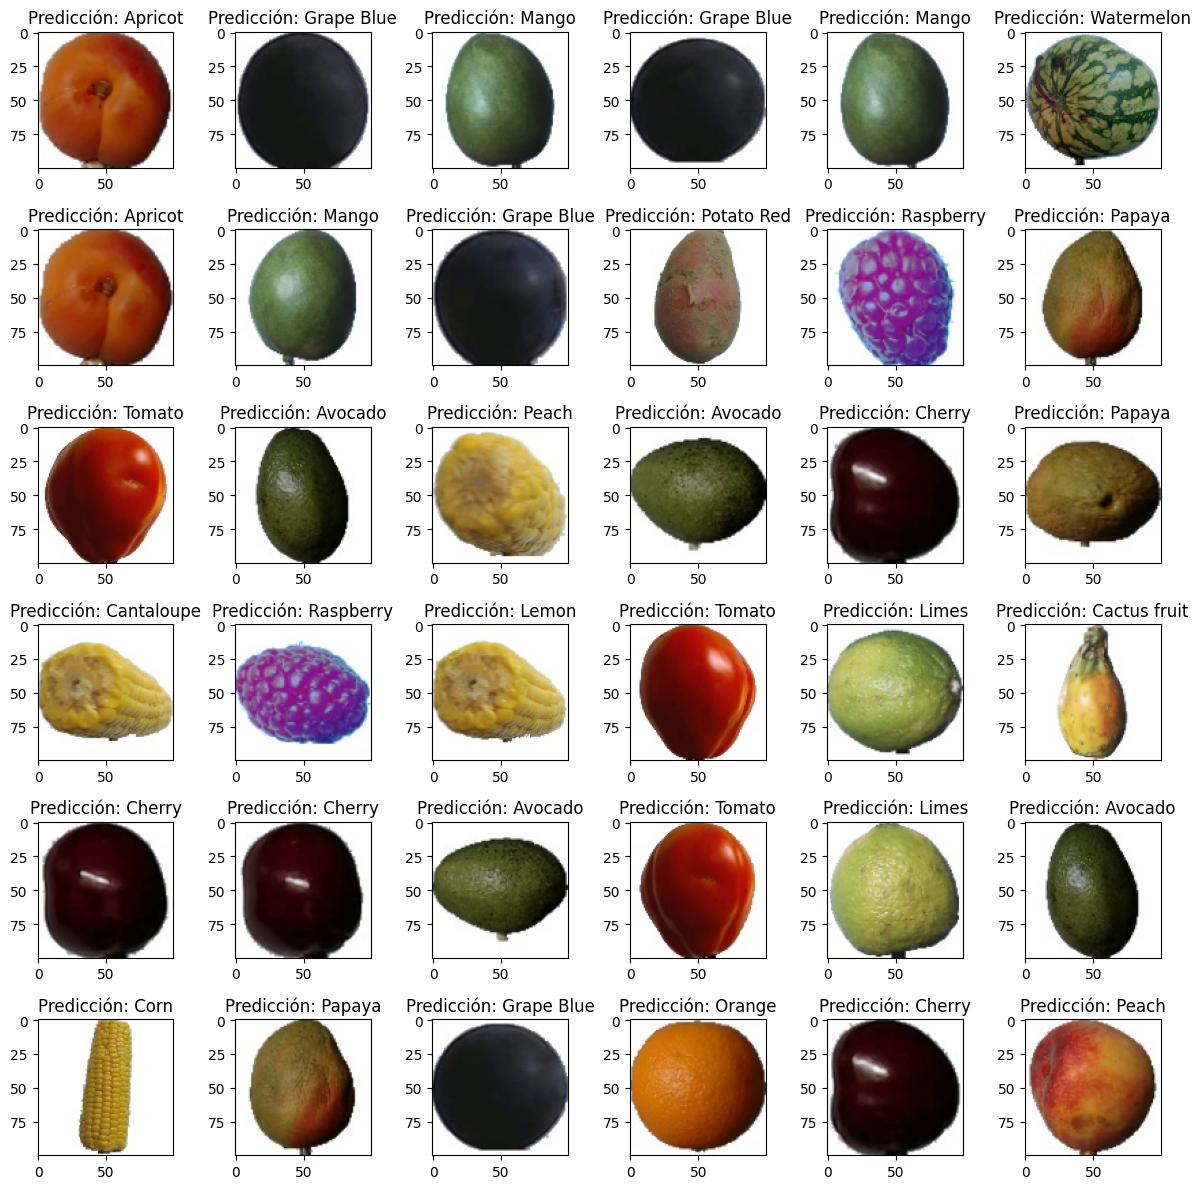

In [52]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Ruta del directorio de imágenes
dir_path = 'Fruit Classification/test/'

# Inicializar subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))

# Iterar sobre las primeras 36 imágenes
for i in range(36):
    # Cargar imagen y convertirla a array
    img = Image.open(f'{dir_path}{i:04}.jpg')
    test_image = np.asarray(img)
    test_image = np.expand_dims(test_image, axis=0)

    # Hacer la predicción
    result = cnn.predict(test_image / 255.0, verbose=False)
    max_index = np.where((result == np.amax(result))[0])[0][0]
    predicted_species = total_data.class_names[max_index]

    # Mostrar imagen y título en el subplot correspondiente
    ax = axs[i//6, i%6]
    ax.imshow(img)
    ax.set_title(f'Predicción: {predicted_species}')
    #ax.axis('off')

# Mostrar la figura
plt.tight_layout()
plt.show()